In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

SPECTRAL_PATH = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20211111_EEG_ECvsEO_spectral_diffs"

# plt.style.use("default_light")

In [2]:
N_FOLDS = 5
N_REPEATS = 20

thresholds = np.linspace(0, 1, 100)


CLASSIEFIERS = {
    # basic logisitc regression
    "logistic regression": LogisticRegression(penalty="l2"),
    # SVM with linear kernel
    "linear SVM": SVC(kernel="linear", C=0.025, probability=True),
    # SVM with nonlinear - RBF - kernel
    "RBF SVM": SVC(gamma=2, C=1, probability=True),
    # AdaBoost
    "AdaBoost": AdaBoostClassifier(),
    # random forest
    "random forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1
    ),
    "nearest neighbours": KNeighborsClassifier(),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
}


def compute_roc_for_multiple(x_train, x_test, y_train, y_test):
    plot_data = {}
    for clf_name, clf in tqdm(CLASSIEFIERS.items()):
        clf.fit(x_train, y_train)
        probs = clf.predict_proba(x_test)[:, 1]
        plot_data[clf_name] = list(roc_curve(y_test, probs))
        plot_data[clf_name].append(roc_auc_score(y_test, probs))

    return plot_data


def manual_roc_curve(true, pred):
    tpr = []
    fpr = []
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(true, pred > thresh).ravel()
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return np.array(tpr), np.array(fpr)


def get_metrics_for_kfold(true, predicted):
    cm = confusion_matrix(true, predicted)
    total = sum(sum(cm))
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / total
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity


def kfold_classifier(clf, x, y, n_folds=N_FOLDS, n_repeats=N_REPEATS):
    tpr, fpr, auc = [], [], []
    acc, sens, spec = [], [], []
    thresholds = np.linspace(0, 1, 100)

    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)
    for train_index, test_index in tqdm(rskf.split(x, y), total=N_FOLDS * N_REPEATS):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(x_train, y_train)
        probs = clf.predict_proba(x_test)[:, 1]
        tpr_, fpr_ = manual_roc_curve(y_test, probs)
        auc_ = roc_auc_score(y_test, probs)
        ideal_threshold_ = thresholds[np.argmax(tpr_ - fpr_)]
        metrics = get_metrics_for_kfold(y_test, probs > ideal_threshold_)
        tpr.append(tpr_)
        fpr.append(fpr_)
        auc.append(auc_)
        acc.append(metrics[0])
        sens.append(metrics[1])
        spec.append(metrics[2])

    return tpr, fpr, auc, acc, sens, spec

In [3]:
df = xr.open_dataarray(
    os.path.join(SPECTRAL_PATH, "epochs_bands_envelopes.nc"), engine="netcdf4"
)
df.name = "band_envelopes"

In [4]:
df

<xarray.DataArray 'band_envelopes' (band: 5, channels: 61, time: 601, data_type: 2, subject_id: 203)>
[74421830 values with dtype=float64]
Coordinates:
  * channels    (channels) object 'AF3' 'AF4' 'AF7' 'AF8' ... 'T8' 'TP7' 'TP8'
  * time        (time) float64 0.0 0.004 0.008 0.01 ... 1.99 1.992 1.996 2.0
  * band        (band) object 'Delta' 'Theta' 'Alpha' 'Beta' 'Gamma'
  * data_type   (data_type) object 'EC' 'EO'
  * subject_id  (subject_id) object 'sub-010002' 'sub-010003' ... 'sub-010321'

In [5]:
reg_data = (
    df.mean(["time", "channels"])
    .to_dataframe()
    .unstack(level=[0])
    .reset_index()
    .set_index("subject_id")
)
reg_data.columns = reg_data.columns.droplevel(0)
reg_data = reg_data.dropna()

In [6]:
x = reg_data[["Delta", "Theta", "Alpha", "Beta", "Gamma"]].values
y = reg_data.iloc[:, 0].replace({"EC": 0, "EO": 1}).values
print(x.shape, y.shape)

(405, 5) (405,)


In [7]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(283, 5) (283,)
(122, 5) (122,)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


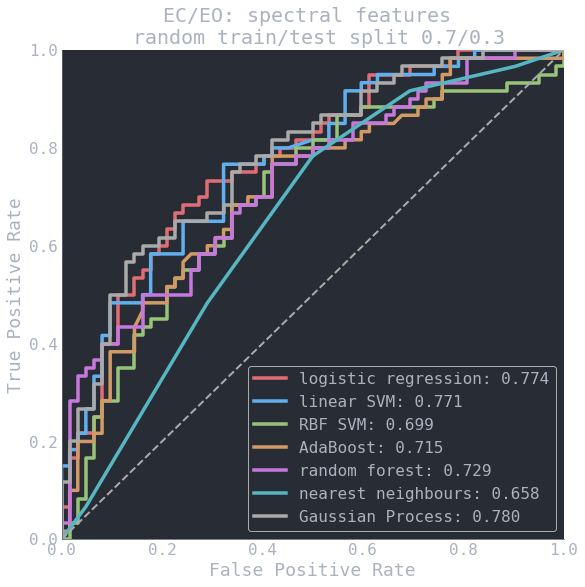

In [8]:
plot_data = compute_roc_for_multiple(x_train, x_test, y_train, y_test)

plt.figure(figsize=(9, 9))
for i, (clf_name, plt_data) in enumerate(plot_data.items()):
    plt.plot(
        plt_data[0],
        plt_data[1],
        color=f"C{i}",
        label=f"{clf_name}: {plt_data[3]:.3f}",
        linewidth=3.5,
    )
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EC/EO: spectral features \n random train/test split 0.7/0.3")
plt.legend()
sns.despine(trim=True)

In [9]:
tpr, fpr, auc, acc, sens, spec = kfold_classifier(
    LogisticRegression(penalty="l2"), x, y
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.27it/s]


---------
Accuracy: 0.728 ± 0.039
Sensitivity: 0.773 ± 0.114
Specificity: 0.683 ± 0.113


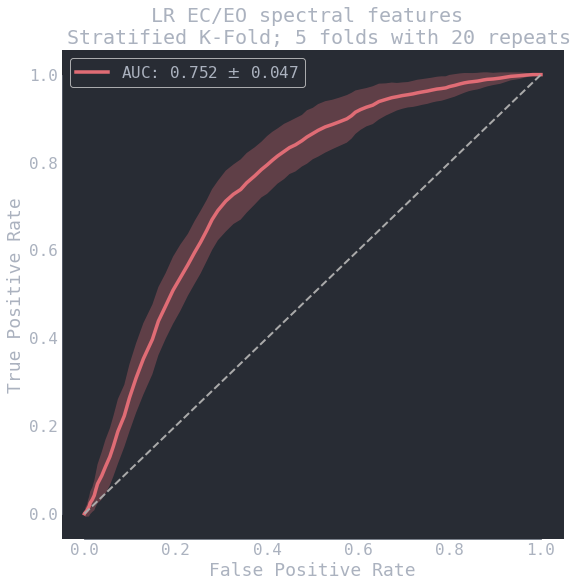

In [10]:
plt.figure(figsize=(9, 9))
tpr = np.vstack(tpr)
fpr = np.vstack(fpr)
mean_auc = np.mean(auc)
std_auc = np.std(auc)
plt.plot(
    fpr.mean(axis=0),
    tpr.mean(axis=0),
    label=f"AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}",
    linewidth=3.5,
)
plt.fill_between(
    fpr.mean(axis=0),
    tpr.mean(axis=0) - tpr.std(axis=0),
    tpr.mean(axis=0) + tpr.std(axis=0),
    alpha=0.3,
)
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(
    f"LR EC/EO spectral features \n Stratified K-Fold; {N_FOLDS} folds with {N_REPEATS} repeats"
)
plt.legend()
sns.despine(trim=True)

print("---------")
print(f"Accuracy: {np.mean(acc):.3f} ± {np.std(acc):.3f}")
print(f"Sensitivity: {np.mean(sens):.3f} ± {np.std(sens):.3f}")
print(f"Specificity: {np.mean(spec):.3f} ± {np.std(spec):.3f}")

In [11]:
tpr, fpr, auc, acc, sens, spec = kfold_classifier(
    GaussianProcessClassifier(1.0 * RBF(1.0)), x, y
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:12<00:00, 13.32s/it]


---------
Accuracy: 0.727 ± 0.037
Sensitivity: 0.764 ± 0.122
Specificity: 0.691 ± 0.116


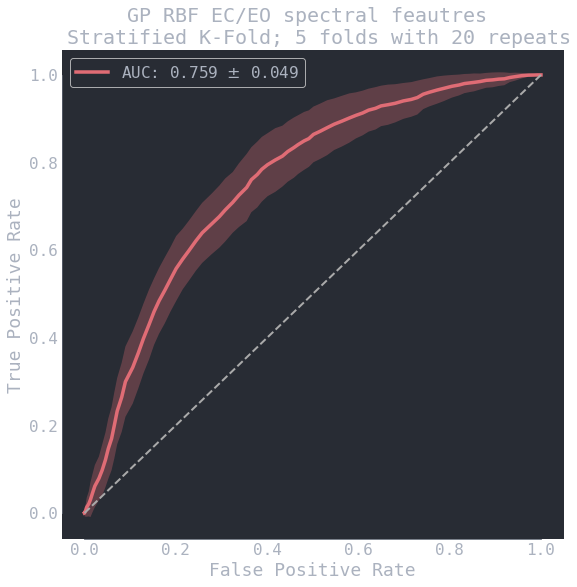

In [12]:
plt.figure(figsize=(9, 9))
tpr = np.vstack(tpr)
fpr = np.vstack(fpr)
mean_auc = np.mean(auc)
std_auc = np.std(auc)
plt.plot(
    fpr.mean(axis=0),
    tpr.mean(axis=0),
    label=f"AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f}",
    linewidth=3.5,
)
plt.fill_between(
    fpr.mean(axis=0),
    tpr.mean(axis=0) - tpr.std(axis=0),
    tpr.mean(axis=0) + tpr.std(axis=0),
    alpha=0.3,
)
plt.plot([0, 1], [0, 1], color="#AAAAAA", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(
    f"GP RBF EC/EO spectral feautres \n Stratified K-Fold; {N_FOLDS} folds with {N_REPEATS} repeats"
)
plt.legend()
sns.despine(trim=True)

print("---------")
print(f"Accuracy: {np.mean(acc):.3f} ± {np.std(acc):.3f}")
print(f"Sensitivity: {np.mean(sens):.3f} ± {np.std(sens):.3f}")
print(f"Specificity: {np.mean(spec):.3f} ± {np.std(spec):.3f}")